# Landweber iteration and Morozov's discrepancy principle
In this lab, you should solve a three-dimensional tomography problem with the Landweber method. Have a look in the course literature to see how this method works, and what Morozov's discrepancy principle is. Here are some general hints:

* Start by choosing an appropriate discretized space with three dimensions and symmetric min/max points around zero, starting with $32 \times 32 \times 32$ resolution for testing, and initialize it with odl. *If you do not have access to a suitable GPU, or if you have not installed the optional dependency with astra-toolbox, then this lab must be done in two dimensions.*

* Create a three-dimensional [Shepp–Logan phantom](https://odlgroup.github.io/odl/generated/odl.phantom.transmission.shepp_logan.html) in the space. Use ``show`` to make sure that the image are centered at the origin. 

* Form the [ray transform operator](http://odlgroup.github.io/odl/generated/odl.tomo.operators.ray_trafo.RayTransform.html) using a [cone beam geometry](http://odlgroup.github.io/odl/generated/odl.tomo.geometry.conebeam.cone_beam_geometry.html#odl.tomo.geometry.conebeam.cone_beam_geometry) with a small number $(\sim 10)$ of angles, otherwise you will not see the effects of semi-convergence. 

* Apply the operator to the phantom to obtain the sinogram, and add some noise to the sinogram (which lives in the space ``Operator.range``). 

* You get the norm of a space element with its [norm method](https://odlgroup.github.io/odl/generated/odl.discr.discr_space.DiscretizedSpaceElement.norm.html#odl.discr.discr_space.DiscretizedSpaceElement.norm). For the discrepancy in the Landweber method, you will need the noise level $\| g - g_{\mathrm{noisy}}\|$ of the sinogram $g$. (In real applications you must estimate the noise level, but let us keep this example simple.)

* Get the adjoint of the forward operator, e.g., ``Operator.adjoint``.

* You can obtain an estimate of the largest singular value of the forward operator with its [norm method](http://odlgroup.github.io/odl/generated/odl.operator.operator.Operator.norm.html). (Note that this is the operator norm, which may need to be estimated with ``estimate=True`` if it is not directly available/precomputed).

* Implement Landweber and employ $\sim 200$ iterations to obtain a sequence of reconstructions $f_n$ from the noisy sinogram, starting with the [zero vector](https://odlgroup.github.io/odl/generated/odl.discr.discr_space.DiscretizedSpace.zero.html#odl.discr.discr_space.DiscretizedSpace.zero) of the space.

* Log the relevant norms between iterations and check if and when the discrepancy criterion is satisfied, that is, when $\| Operator(f_n) - g_{\mathrm{noisy}} \| \approx \|g - g_{\mathrm{noisy}}\|$ (but do not stop the iterations).

* Plot the relative error of your reconstructions against the number of iterations, and see what the discrepancy criterion would give you.

* Compare your solution to that obtained with the [built-in version of Landweber](https://odlgroup.github.io/odl/generated/odl.solvers.iterative.iterative.landweber.html#odl.solvers.iterative.iterative.landweber).

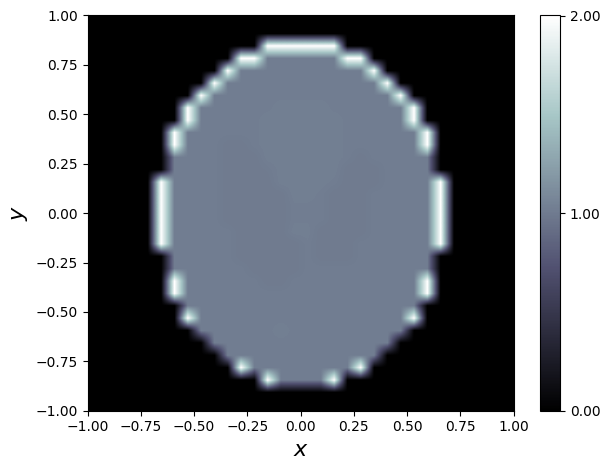

<Figure size 640x480 with 0 Axes>

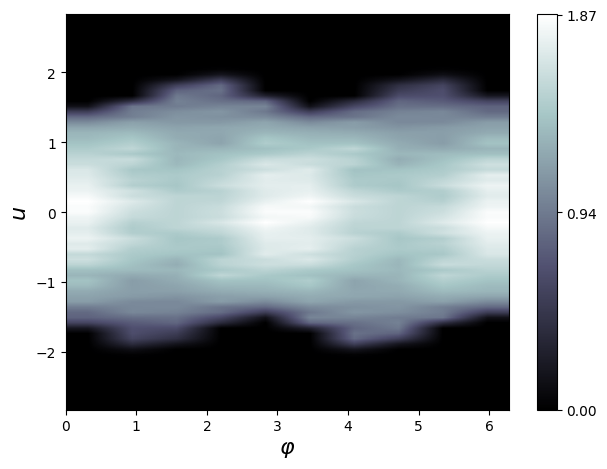

<Figure size 640x480 with 0 Axes>

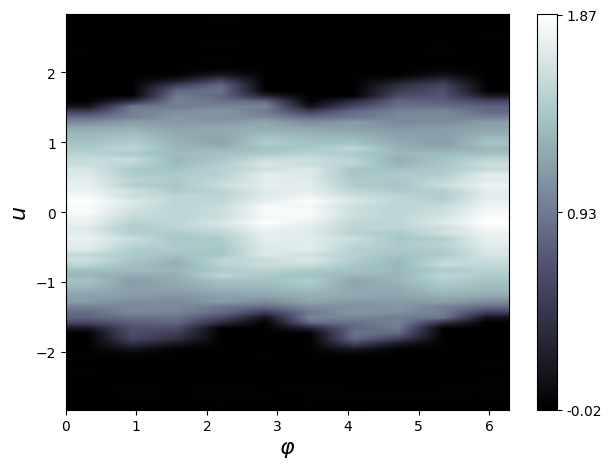

<Figure size 640x480 with 0 Axes>

Norm of noise:  0.07859464443195643
Norm of A:  7.63713991198


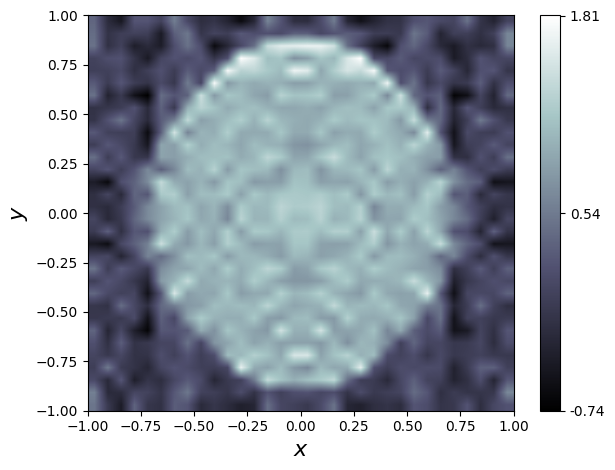

<Figure size 640x480 with 0 Axes>

Final error norm in X:  0.5316919329595859
Final reconstruction error norm in Y:  0.11175223263346873


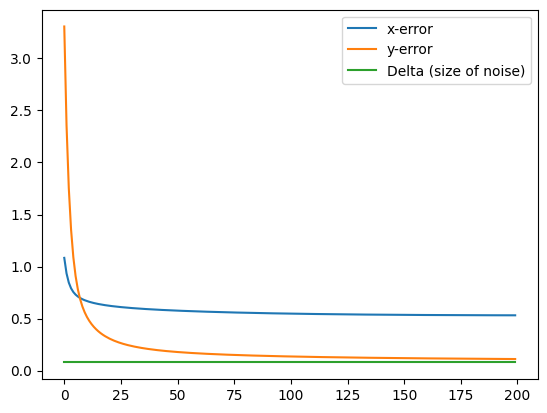

Built in X-error: 0.531666469399034
Built in Y-error: 0.11165909223175051


In [14]:
import odl
import numpy as np
import matplotlib.pyplot as plt

space = odl.uniform_discr([-1,-1,-1],[1,1,1], 32)

phant = odl.phantom.transmission.shepp_logan(space)
phant.show()

geo = odl.tomo.geometry.conebeam.cone_beam_geometry(space,2.0, 2.0, num_angles=10)

A = odl.tomo.operators.ray_trafo.RayTransform(space, geo, impl='astra_cuda')

Q = A(phant)

Q.show()
q = Q + odl.phantom.noise.white_noise(A.range, stddev=0.005)
q.show()
A_adj = A.adjoint

noise_norm = (Q-q).norm()

a_norm = A.norm(estimate=True)

print("Norm of noise: ", noise_norm)
print("Norm of A: ", a_norm)

N = 200 # reg_param = 1/N
tau = 1.0 / (a_norm**2) 

iters = []
x_errors = []
y_errors = []
u = space.zero()
for k in range(N):
    u += tau * (A_adj(q - A(u)))
    iters.append(u)
    x_errors.append((u-phant).norm())
    y_errors.append((q-A(u)).norm())

u.show()

print("Final error norm in X: ", (u-phant).norm())
print("Final reconstruction error norm in Y: ", (q-A(u)).norm())

plt.figure()
plt.plot(x_errors, label="x-error")
plt.plot(y_errors, label="y-error")
plt.plot(noise_norm * np.ones(N), label="Delta (size of noise)")
plt.legend()
plt.show()

u_lw = space.zero()
odl.solvers.iterative.iterative.landweber(A,u_lw,q,N)
print("Built in X-error:", (u_lw-phant).norm())
print("Built in Y-error:", (A(u_lw)-q).norm())
